# Analysis of baseline mobility network

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn import metrics
import seaborn as sns

import matplotlib.gridspec as gridspec
from math import log


In [2]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import remove_self_loops, visualse_largest_components
from utils import R2_score

root_figure = path+"/figures/"
root_map = path+'/data/geo_shapefiles//NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
root_baseline_data = path+'/data/fb_movement_maps/BETWEEN_TILES_BASELINE.csv'
root_processed = path+"/data/processed/"
root_networks = path+"/data/processed/networks/"
root_results = path+"/results/"

In [3]:
plt.rcParams.update({'font.size': 20})

## Import LSCC 

In [4]:
#################
# Load datasets #
#################

# Load LSCC
root_lscc = root_networks+'/base_network_lscc.npz'
with open(root_lscc, 'rb') as handle:
        lscc_dict = pickle.load(handle)
        
##############################
# Generate DiGraph from data #
##############################

lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)
lscc_nodes = list(lscc.nodes())
n_nodes = len(lscc_nodes)

# Store node numbers
node_numbers = {i : lscc_nodes[i] for i in range(n_nodes)}

# Load geom_dict
root_geom_dict = root_networks+'/base_geom_dict.pickle'
with open(root_geom_dict, 'rb') as handle:
        geom_dict = pickle.load(handle)
# Gemo dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
A_LSCC_array = A_LSCC.toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

# Subtract self-loops
B_LSCC_array = A_LSCC - np.diag(np.diag(A_LSCC.toarray()))
B_LSCC = sp.csr_matrix(B_LSCC_array)

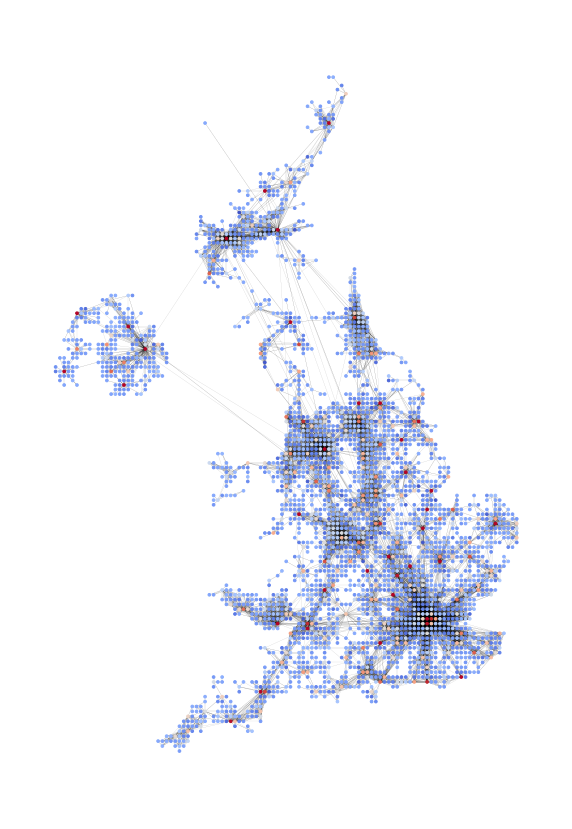

In [5]:
# Compute pagerank
pr_lscc = np.asarray(list(dict(nx.pagerank(lscc)).values())) 

# Create subplot and draw graph
fig, ax = plt.subplots(1,figsize =(10,15))
nx.draw(remove_self_loops(lscc), ax=ax,pos=geom_dict_numbers,node_size=7, width = 0.05, arrows = False,
       node_color=pr_lscc,cmap = 'coolwarm',vmax = np.percentile(pr_lscc,99))
plt.show()
#fig.savefig(root_figure+'LSCC_PageRank.pdf', dpi=fig.dpi,bbox_inches='tight')

## Dynamical properties of LSCC and detailed balance

In [6]:
# Compute stationary distribution
graph = B_LSCC
dinv = np.asarray(np.divide(1,graph.sum(axis=1),where=graph.sum(axis=1)!=0))
Dinv = np.diag(dinv.reshape(-1))
M = Dinv*graph
M = sp.csr_matrix(M)
pi = abs(sp.linalg.eigs(M.transpose(), which='LM', k=1)[1][:, 0])
pi /= pi.sum()

# Generate uniform distribution
uniform = np.ones(n_nodes)/n_nodes

In [7]:
d_out = np.asarray(np.sum(B_LSCC_array,axis=1)).flatten()
psi = d_out/np.sum(d_out)

In [8]:
R2_score(pi, d_out)

0.9681388048640518

In [9]:
np.linalg.norm(pi)

0.04839404559891989

In [10]:
np.linalg.norm(psi)

0.05531410377825794

In [11]:
np.linalg.norm(pi-psi)

0.011401300809780454

In [12]:
# Compute column sums
column_sum = np.sum(M,axis = 0)
ones = np.ones(n_nodes)
print('Frobenius distance between column sums and 1:', 
      np.around(np.linalg.norm(column_sum-ones),2))

Frobenius distance between column sums and 1: 106.29


/home/tc/anaconda3/envs/mobility/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


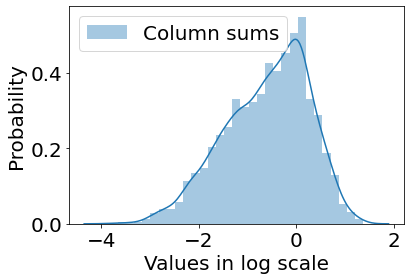

In [13]:
ax = sns.distplot(np.log10(column_sum), label = 'Column sums')
ax.set(xlabel = 'Values in log scale', ylabel = 'Probability')
ax.legend()
plt.show()

Matrix is not doubly-stochastic!

In [14]:
print('MAE for stationary vs. uniform distribution:',
      np.around(metrics.mean_absolute_error(pi,uniform),5))

print('RMSE for stationary vs. uniform distribution:',
      np.around(np.sqrt(metrics.mean_squared_error(pi,uniform)),5))

MAE for stationary vs. uniform distribution: 0.00039
RMSE for stationary vs. uniform distribution: 0.0008


/home/tc/anaconda3/envs/mobility/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


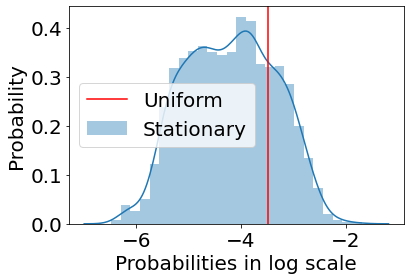

In [15]:
ax = sns.distplot(np.log10(pi), label = 'Stationary')
ax.axvline(x = np.log10(uniform[0]), color = 'red',
          label = 'Uniform')
ax.set(xlabel = 'Probabilities in log scale', ylabel = 'Probability')
ax.legend()
plt.show()

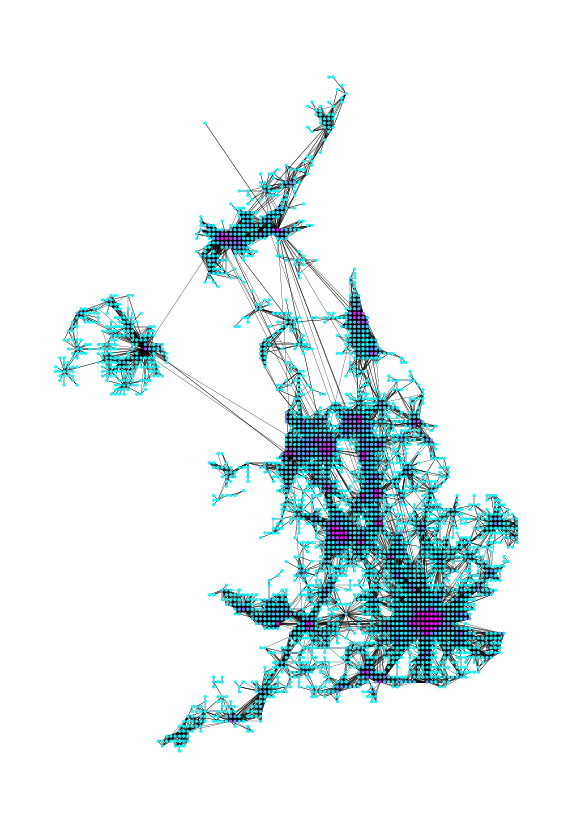

In [16]:
# Create subplot and draw graph
fig, ax = plt.subplots(1,figsize =(10,15))

# Draw citation graph and color w.r.t. communities
nx.draw(remove_self_loops(lscc), ax=ax,pos=geom_dict_numbers,node_size=5, width = 0.3, arrows = False, #edge_color = 'grey',
       node_color=pi,cmap = 'cool',vmax = np.percentile(pi,99))

plt.show()

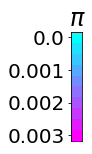

In [17]:
# Create subplot and draw graph
fig, ax = plt.subplots(1,figsize =(2,2))

range_pi = np.asarray([100,4000,9000,13000,17000,21000,25000,30000,340000,38000])

ax.imshow(np.linspace(np.min(pi),np.percentile(pi,99),10).reshape(10,1),
           cmap='cool')
ax.set(xticks=[],yticks = np.arange(0,10,3),
        yticklabels=np.around(np.linspace(np.min(pi),np.percentile(pi,99),10),4)[np.arange(0,10,3)],
        title=r'$\pi$')
plt.show()

### Detailed balance

In [18]:
Pi = sp.csr_matrix(np.diag(pi))
nominator = M.transpose().dot(Pi) - Pi.dot(M)
denominator = M.transpose().dot(Pi) + Pi.dot(M)

/tmp/ipykernel_73262/3117749357.py:2: RuntimeWarning: divide by zero encountered in log10
  ax = sns.histplot(np.log10(abs((nominator.toarray())[M.toarray()!=0])))#, label = r'$|\Pi M-M^T\Pi|$')


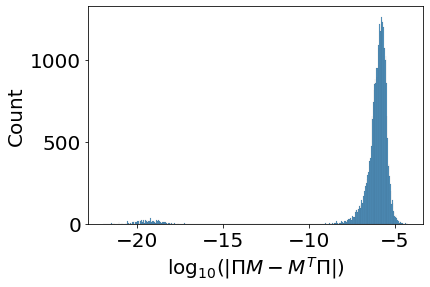

In [19]:
#ax = sns.distplot(np.log10(m1[m1!=0]), label = 'Pi*M')
ax = sns.histplot(np.log10(abs((nominator.toarray())[M.toarray()!=0])))#, label = r'$|\Pi M-M^T\Pi|$')

# ax.axvline(x = np.log10(uniform[0]), color = 'red',
#           label = 'Uniform')
ax.set(xlabel = r'$\log_{10}(|\Pi M-M^T\Pi|)$', ylabel = 'Count')
#ax.legend()
plt.show()

In [20]:
print('|Pi*M|_F =', 
      np.around(sp.linalg.norm(Pi.dot(M)),5))
print('|Pi*M-M^T*Pi|_F =', 
      np.around(sp.linalg.norm(nominator),5))
print('|Pi*M+M^T*Pi|_F =', 
      np.around(sp.linalg.norm(denominator),5))
print('|Pi*M-M^T*Pi|_F / |Pi*M+M^T*Pi|_F =', 
      np.around(sp.linalg.norm(nominator)/sp.linalg.norm(denominator),5))

|Pi*M|_F = 0.01486
|Pi*M-M^T*Pi|_F = 0.00049
|Pi*M+M^T*Pi|_F = 0.02972
|Pi*M-M^T*Pi|_F / |Pi*M+M^T*Pi|_F = 0.01655


In [21]:
0.00049/0.01486

0.03297442799461642

/tmp/ipykernel_73262/2676718192.py:2: RuntimeWarning: invalid value encountered in true_divide
  PDB = ((abs(nominator.toarray())/denominator.toarray())[M.toarray()!=0])


80th Quantile PDB: 0.26592607541122554


/tmp/ipykernel_73262/2676718192.py:7: RuntimeWarning: invalid value encountered in true_divide
  PRA = (abs(B- B.transpose())/(B + B.transpose()))[B>0]


80th Quantile PRA: 0.33929800412938754


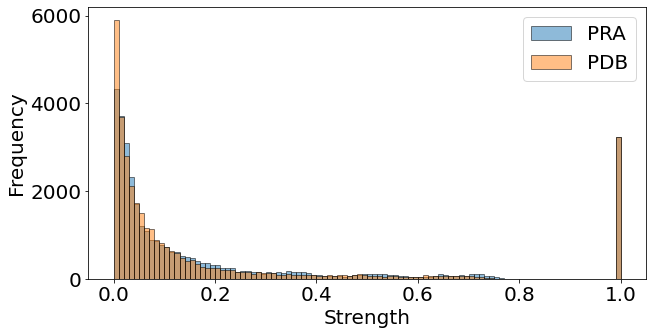

In [22]:
# Compute pairwise detailed balance
PDB = ((abs(nominator.toarray())/denominator.toarray())[M.toarray()!=0])
print("80th Quantile PDB:", np.quantile(PDB,0.80))

# Compute absolute errors, i.e. pairwise relative asymmetry
B = B_LSCC.toarray()
PRA = (abs(B- B.transpose())/(B + B.transpose()))[B>0]
print("80th Quantile PRA:", np.quantile(PRA,0.80))

# Plot histogram for pairwise relative asymmetry
fig, ax = plt.subplots(1,figsize =(10,5))
ax.hist(PRA,100,alpha=0.5, edgecolor='black',label='PRA')

# Plot histogram for pairwise detailed balance
ax.hist(PDB,100,alpha=0.5, edgecolor='black',label='PDB')
ax.set(xlabel = 'Strength',ylabel='Frequency')#,yscale='log')
ax.legend()

plt.show()

fig.savefig(root_figure+'PRA_PDB.pdf', dpi=fig.dpi,bbox_inches='tight')

In [23]:
# the one-way connections are exactly the ones that have PDB=1
sum((PDB == 1) * (PRA == 1))

3226

In [24]:
np.quantile(PDB,0.75)

0.18221911070488842

In [25]:
PDB_matrix = np.nan_to_num((abs(nominator.toarray())/denominator.toarray()))

# compute graph with edges that have PDB smaller Q1
PDB_Q1 = PDB_matrix.copy()
PDB_Q1[PDB_Q1>np.quantile(PDB,0.25)] = 0
G_PDB_Q1 = nx.from_numpy_array(PDB_Q1)

# compute graph with edges that have PDB bigger Q3
PDB_Q3 = PDB_matrix.copy()
PDB_Q3[PDB_Q3<np.quantile(PDB,0.75)] = 0
#PDB_Q3[PDB_Q3==1] = 0
G_PDB_Q3 = nx.from_numpy_array(PDB_Q3)

/tmp/ipykernel_73262/3099854255.py:1: RuntimeWarning: invalid value encountered in true_divide
  PDB_matrix = np.nan_to_num((abs(nominator.toarray())/denominator.toarray()))


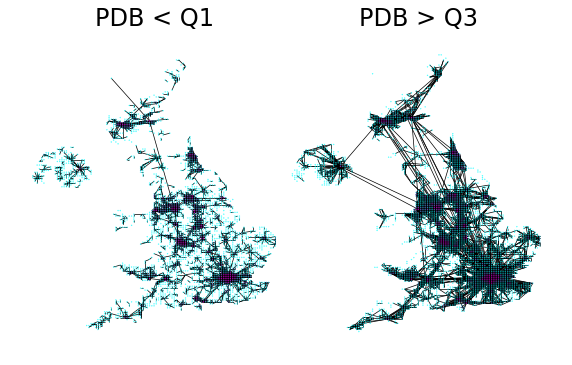

In [26]:
fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(wspace=-0.1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nx.draw(G_PDB_Q1, ax=ax1,pos=geom_dict_numbers,node_size=0.1, width = 0.7, 
        arrows = False, node_color=pi,cmap = 'cool',vmax = np.percentile(pi,99))
ax1.set(title='PDB < Q1')

nx.draw(G_PDB_Q3, ax=ax2,pos=geom_dict_numbers,node_size=0.1, width = 0.7, 
        arrows = False, node_color=pi,cmap = 'cool',vmax = np.percentile(pi,99))
ax2.set(title='PDB > Q3')

plt.show()

### Corellations of $\pi$ with other quantities

In [27]:
self_loops = np.diag(A_LSCC_array)

In [28]:
print("R2 score of pi and d_out: ", R2_score(pi, d_out))
print("R2 score of pi and A_ii: ", R2_score(pi, self_loops))
print("R2 score of d_out and A_ii: ", R2_score(d_out, self_loops))

R2 score of pi and d_out:  0.9681388048640518
R2 score of pi and A_ii:  0.8328598510563936
R2 score of d_out and A_ii:  0.7651712858042974


/home/tc/anaconda3/envs/mobility/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/tc/anaconda3/envs/mobility/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


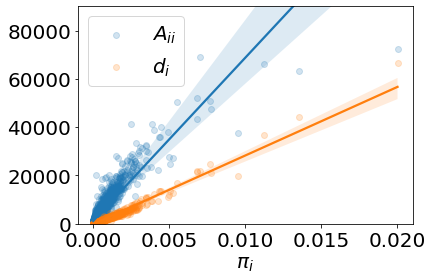

In [29]:
fig, ax = plt.subplots(1)
sns.regplot(pi,self_loops, ax=ax,label=r'$A_{ii}$',scatter_kws={'alpha' : 0.2})
sns.regplot(pi,d_out, ax=ax,label=r'$d_i$',scatter_kws={'alpha' : 0.2})
ax.set(xlabel=r'$\pi_i$', ylim = (0,90000))#,yscale='log')
ax.legend()
fig.savefig(root_figure+'Pi_correlations.pdf', dpi=fig.dpi,bbox_inches='tight')
#plt.show()

## Markov Stability (MS) analysis

We perform MS analyis on a server using the python script `src/ms_analysis.py`

### Scale selection

In [31]:
# Load data (deserialize)
with open(root_results+"MS_results_2.pkl", 'rb') as handle:
    all_results = pickle.load(handle)

In [32]:
# Get times
times = all_results['times']
min_time = all_results['run_params']['min_time']
max_time = all_results['run_params']['max_time']
n_time = all_results['run_params']['n_time']
log_times = np.linspace(min_time,max_time,n_time)

# Get information about communities
community_id = np.asarray(all_results['community_id'])
n_communities  = np.asarray(all_results['number_of_communities'])
n_times = len(n_communities)

In [9]:
from pygenstability import plotting
from pygenstability.optimal_scales import identify_optimal_scales

In [11]:
kernel_size = 10
window_size = 20
max_nvi = 1#0.047
basin_radius = 3

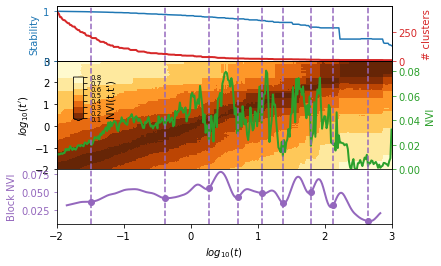

In [12]:
# select optimal scales with nvi
identify_optimal_scales(all_results,kernel_size=10,window_size=20,basin_radius=3)

# plot summary of ms
plotting.plot_scan(all_results)
plt.show()

In [33]:
robust_scales = all_results["selected_partitions"]
block_nvi = all_results["block_detection_curve"]

### Summary plot

In [34]:
import matplotlib.gridspec as gridspec

In [35]:
# The following code for plotting the results of Markov Stability analysis
# originates from the PyGenStability package and is only slightly modified

def plot_scan_plt(all_results, robust_scales, block_detection_curve, time_axis=True):
    """Plot results of pygenstability with matplotlib."""
    plt.figure(figsize=(10,12))
    gs = gridspec.GridSpec(3, 2, height_ratios=[0.3, 1.0,0.5], width_ratios=[1,0.1])
    gs.update(hspace=0)
    gs.update(wspace=0.1)

    ax0 = plt.subplot(gs[0, 0])
    plot_number_comm(all_results, ax=ax0, time_axis=time_axis)
    ax0.set_xticks([])

    ax2 = plt.subplot(gs[1, 0])
    im = plot_ttprime(all_results, ax=ax2, time_axis=time_axis)
    ax2.set_xticks([])
    
    
    ax3 = ax2.twinx()
    plot_scale_selection(all_results, robust_scales, block_detection_curve, ax=ax3, time_axis=time_axis)
    ax2.yaxis.tick_right()
    ax3.yaxis.tick_left()


    ax4 = plt.subplot(gs[1, 1])
    ax4.axis('off')
    plt.colorbar(im,shrink = 10, label = "NVI(s,s')")

    ax3.set_xticks([])
    ax4.set_xticks([])
    ax5 = plt.subplot(gs[2,0])
    plot_variation_information(all_results, ax=ax5, time_axis=time_axis)
    
    
    # Mark relevent times
    for i in robust_scales:
        ax3.axvline(x = log_times[i], ls="--", color = 'red',zorder=10)
        ax5.axvline(x = log_times[i], ls="--", color = 'red',zorder=10)
        
        
    return ax0, ax3, ax5


def _get_times(all_results, time_axis=True):
    """Get the time vector."""
    if not time_axis:
        return np.arange(len(all_results["times"]))
    if all_results["run_params"]["log_time"]:
        return np.log10(all_results["times"])
    return all_results["times"]


def plot_number_comm(all_results, ax, time_axis=True):
    """Plot number of communities."""
    times = _get_times(all_results, time_axis)

    ax.plot(
        times, all_results["number_of_communities"], "-", c="C0", label="size", lw=2.0
    )
    ax.set_ylabel("#comm.", color="C0")
    ax.tick_params("y", colors="C0")
    ax.axis([times[0], times[-1],  np.min(all_results["number_of_communities"]) * 0.9, 
             np.max(all_results["number_of_communities"]) * 1.1])
    
    ax.set(yscale='log')

    for i in robust_scales:
        ymax = 1 
        ax.axvline(x = log_times[i], ymax = ymax , ls="--", color = 'red',zorder=10)


def plot_ttprime(all_results, ax, time_axis):
    """Plot ttprime."""
    times = _get_times(all_results, time_axis)

    im = ax.contourf(times, times, all_results["ttprime"], cmap="YlOrBr_r")
    ax.set_ylabel(r"$s^\prime$")
    
    ax.axis([times[0], times[-1], times[0], times[-1]])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    #ax.set(sitle='Selection of most relevant scales in Markov Stability analysis')
    
    return im


def plot_variation_information(all_results, ax, time_axis=True):
    """Plot variation information."""
    times = _get_times(all_results, time_axis=time_axis)
    ax.plot(times, all_results["variation_information"], "-", lw=2.0, c="C2", label="VI")

    ax.yaxis.tick_left()
    ax.tick_params("y", colors="C2")
    ax.set_ylabel("NVI(s)", color="C2")
    
    ax.yaxis.set_label_position("left")
    #ax.axhline(1, ls="--", lw=1.0, c="C2")
    ax.axis([times[0], times[-1], np.min(all_results["variation_information"]) * 0.9, 
             np.max(all_results["variation_information"]) * 1.1])
    ax.set_xlabel(r"$s$")


def plot_stability(all_results, ax, time_axis=True):
    """Plot stability."""
    times = _get_times(all_results, time_axis=time_axis)
    ax.plot(times, all_results["stability"], "-", label=r"$Q$", c="C0")

    ax.yaxis.tick_right()
    ax.tick_params("y", colors="C0")
    ax.set_ylabel("Stability", color="C0")
    ax.yaxis.set_label_position("right")
    ax.set_xlabel(r"$log_{10}(s)$")
    ax.axis([times[0], times[-1],  np.min(all_results["stability"]) * 0.9, 
             np.max(all_results["stability"]) * 1.1])

def plot_scale_selection(all_results, robust_scales, block_detection_curve, ax, time_axis=True):
    
    # plot
    color = 'black'
    times = _get_times(all_results, time_axis=time_axis)
    for i in robust_scales:
            ax.axvline(x=times[i], ls="--", color = 'red',alpha=1)
    #ax.axhline(y=max_nvi_tt, ls = ':', color = 'black')
    ax.plot(times, block_detection_curve, color=color, alpha=1)
    ax.set(xlabel=r"$log_{10}(s)$", ylabel = 'NVI')

    ax.tick_params("y", colors=color)
    ax.set_ylabel(r"Pooled diagonal", color=color)
    ax.yaxis.set_label_position("left")
    # ax.set_xlabel(r"$log_{10}(s)$")
    ax.set(xlim=(times[0], times[-1])) 

/tmp/ipykernel_73262/3178414463.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im,shrink = 10, label = "NVI(s,s')")


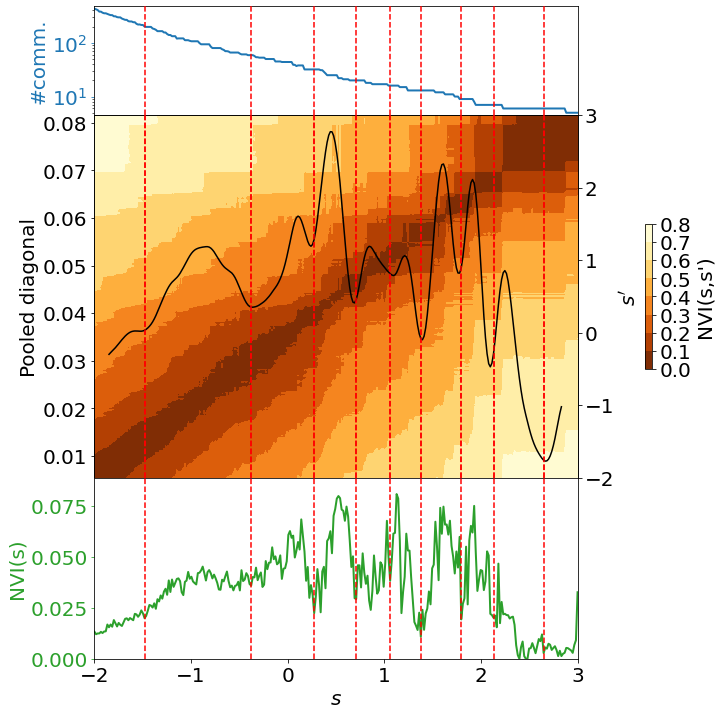

In [36]:
ax0, ax3, ax5 = plot_scan_plt(all_results,robust_scales, block_nvi)
fig = ax3.get_figure()
#plt.show()
fig.savefig(root_figure+'MS_scan.pdf', dpi=fig.dpi,bbox_inches='tight')

### Statistics of MS partitions

In [37]:
community_id_ranked = community_id.copy()

for time in range(n_times):
    # Compute sizes of each community
    labels_graph_counts = np.histogram(community_id[time],bins=np.arange(0,n_communities[time]+1)) [0]
    # Get class indices sorted according to size
    community_ranked = np.argsort(-labels_graph_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {community_ranked[k] : k for k in range(0,n_communities[time])}
    # Apply permutation to labels
    labels_community = community_id[time].copy()
    for i in range (0,len(labels_community)):
        labels_community[i] = rank[labels_community[i]]
    
    community_id_ranked[time] = labels_community

In [38]:
max_c = []
Q1_c = []
Q2_c = []
Q3_c = []
min_c = []

for i in robust_scales:

    partition = community_id_ranked[i]
    labels_graph_counts = np.histogram(partition,bins=np.arange(0,n_communities[i]+1)) [0]
    max_c.append(int(np.max(labels_graph_counts)))
    Q1_c.append(int(np.percentile(labels_graph_counts, q =25)))
    Q2_c.append(int(np.percentile(labels_graph_counts, q =50)))
    Q3_c.append(int(np.percentile(labels_graph_counts, q =75)))
    min_c.append(int(np.min(labels_graph_counts)))
    
community_stats = pd.DataFrame({'Markov times' : np.around(log_times[robust_scales],2),
                                'n_communities' : n_communities[robust_scales], 'min_size' : min_c,
                                'Q1':Q1_c, 'Q2' : Q2_c, 'Q3' : Q3_c, 'max_size' : max_c})

In [39]:
community_stats

,Markov times,n_communities,min_size,Q1,Q2,Q3,max_size
0,-1.48,201,1,7,13,22,59
1,-0.38,59,4,34,49,67,169
2,0.27,32,10,67,87,116,246
3,0.71,20,42,98,133,201,348
4,1.06,16,9,107,168,274,468
5,1.38,13,9,126,263,313,590
6,1.80,9,186,246,274,376,816
7,2.13,7,190,260,319,560,975
8,2.65,6,190,253,365,835,997


## Semi-hierachy

### a) Sankey diagram

In [40]:
# The following code for plotting the results of Markov Stability analysis
# originates from the PyGenStability package and is only slightly modified

import plotly.graph_objects as go

time_index=robust_scales

sources = []
targets = []
values = []
shift = 0


all_results['community_id_reduced']  = [community_id_ranked[i] for i in time_index] 


#for i in range(len(all_results['community_id']) - 1):
for i in range(len(all_results['community_id_reduced']) - 1):
    community_source = np.array(all_results['community_id_reduced'][i])
    community_target = np.array(all_results['community_id_reduced'][i + 1])
    source_ids = set(community_source)
    target_ids = set(community_target)
    for source in source_ids:
        for target in target_ids:
            value = sum(community_target[community_source == source] == target)
            if value > 0:
                values.append(value)
                sources.append(source + shift)
                targets.append(target + len(source_ids) + shift)
    shift += len(source_ids)

layout = go.Layout(autosize=True)
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=1,
                thickness=1,
                line=dict(color="black", width=0.0)
            ),

            link=dict(source=sources, target=targets, value=values),
        )
    ],
    layout=layout,
)

fig.show()
fig.write_image(root_figure+"Sankey_Optimal_Partitions.pdf", format='pdf')

### b) conditional entropy

see: https://en.wikipedia.org/wiki/Mutual_information#Properties

and Lambiotte et al. 2009: belongs to the interval [0, 1], but is now an asymmetric quantity that vanishes only if each community of Pt is the union of communities of Pt

In [41]:
def entropy(labels):
    """Calculates the entropy for a labeling.
    Parameters
    ----------
    labels : int array, shape = [n_samples]
        The labels
    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - log(pi_sum)))

def variation_of_information(x,y, normalised = True):
    Ex = entropy(x)
    Ey = entropy(y)
    I = metrics.mutual_info_score(x,y)
    
    if normalised:
        return  (Ex + Ey - 2*I) / (Ex + Ey - I)
    else: 
        return Ex + Ey - 2*I

def normalised_conditional_entropy(x,y):
    """
    H(X|Y) = H(X) - I(X,Y) and we normalise with log(N)
    """
    
    N = len(x)
    Ex = entropy(x)
    I = metrics.mutual_info_score(x,y)

    return (Ex - I) / np.log(N)

In [43]:
NCE_lower = np.zeros((n_time,n_time))

for t in range(n_time):
    for t_prime in range(t):
        NCE_lower[t,t_prime] = normalised_conditional_entropy(community_id_ranked[t],community_id_ranked[t_prime])

In [44]:
import matplotlib.patches as mpatches

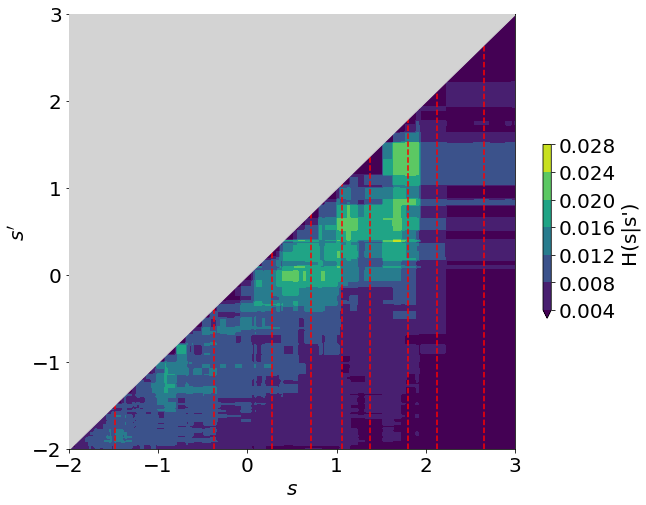

In [45]:
fig, ax = plt.subplots(1,figsize =(10,8))
times = _get_times(all_results, True)
im = ax.contourf(times, times, NCE_lower.transpose(),extend = 'min')
ax.set_ylabel(r"$s^\prime$")
ax.set_xlabel(r"$s$")
ax.axis([times[0], times[-1], times[0], times[-1]])

for i in robust_scales:
    ax.axvline(x = log_times[i], ls="--", color = 'red',zorder=10)

# plot lower diag patch
tmin = times[0]
tmax = times[-1]

ax.add_patch(
    mpatches.Polygon(
        [[tmin, tmin], [tmin, tmax], [tmax, tmax]], fill=True, zorder=20, color="lightgrey"
    )
)

plt.colorbar(im,shrink = 0.4, label = "H(s|s')")

fig.savefig(root_figure+'NCE.pdf', dpi=fig.dpi,bbox_inches='tight')